# Running Monte Carlo over real files

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random 
import urllib.request
import json
from   collections import OrderedDict

import astropy.coordinates as coord
import astropy.units as u
from   astropy import time as t

import poliastro
from poliastro.bodies   import Earth
from poliastro.twobody  import Orbit
from poliastro.plotting import plot

import emcee

# Loading multiple files with a SINGLE satellite

In [2]:
c = 299792.458  # km/s

def get_redshift(f_c, f_m):
    z = (f_m - f_c)/f_c
    return z
    
def get_v_radial(f_c, f_m):
    v_r = c * get_redshift(f_c, f_m)
    return v_r

In [3]:
file_list = ['first_test/001_20190721T052832_jena.json',
             'first_test/001_20190721T052821_leipzig.json',
             'first_test/001_20190721T052801_settrup.json',
             'first_test/001_20190721T052806_stuttgart.json']

N = len(file_list)

In [4]:
raw_data = []

for filename in file_list:
    with open( filename, 'r') as myfile:
        data=myfile.read()
        raw_data.append(data)

In [5]:
json_files = []

for i in range(N):
    obj = json.loads(raw_data[i])
    json_files.append(obj)

In [6]:
gs_geodetic_locs = []

for i in range(N):
    gs_geodetic_locs.append( json_files[i]['groundstation'])


# Get Doppler Shift data from F_c and F_m

In [7]:
f_c = obj['data'][0]['channel_f_center']

In [8]:
tau = []
z = []

for i in range(N):
    
    print("Sat ID: {}".format(json_files[i]['data'][0]['sat_id']))
    stream = json_files[i]['data'][0]['stream']
    
    aux_tau = []
    aux_z   = []
    
    for s in stream:
        aux_tau.append( float(s['time_system']))
        aux_z.append( get_redshift(f_c, float(s['f']) ))

    print("Stream length: {}".format(len(aux_z)))
    tau.append(aux_tau)
    z.append(aux_z)

        

Sat ID: 1
Stream length: 396
Sat ID: 1
Stream length: 401
Sat ID: 1
Stream length: 389
Sat ID: 1
Stream length: 392


In [9]:
for i in range(N):
    print(len(tau[i]))

396
401
389
392


### Doppler Shift measured by Ground Stations

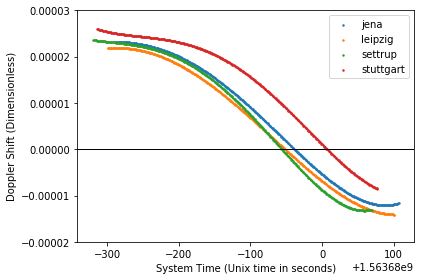

In [10]:
fig = plt.figure(figsize=(6,4))
plt.axhline(0, c="k", lw=1)

for i in range(N):
    
    label = gs_geodetic_locs[i]['gs_name']
    plt.scatter(tau[i], z[i], s=2, label=label)
    
plt.ylim(-2e-5,3e-5)
plt.xlabel("System Time (Unix time in seconds)")
plt.ylabel("Doppler Shift (Dimensionless)")
plt.legend(loc=0)

plt.tight_layout()
plt.savefig("first_test/measured_doppler_shift.png")

### Calculating GS positions and velocities in the GeoCentric Reference System

In [11]:
gs_geodetic_locs

[{'gs_id': None,
  'gs_name': 'jena',
  'gs_lon': 11.56886,
  'gs_lat': 50.91847,
  'gs_alt': 130.0},
 {'gs_id': None,
  'gs_name': 'leipzig',
  'gs_lon': 12.338261,
  'gs_lat': 51.336569,
  'gs_alt': 80.0},
 {'gs_id': None,
  'gs_name': 'settrup',
  'gs_lon': 7.6289,
  'gs_lat': 52.49356,
  'gs_alt': 40.0},
 {'gs_id': None,
  'gs_name': 'stuttgart',
  'gs_lon': 9.2356,
  'gs_lat': 48.777,
  'gs_alt': 230.0}]

In [12]:
GS = []

for i in range(N):
    lon = gs_geodetic_locs[i]['gs_lon']
    lat = gs_geodetic_locs[i]['gs_lat']
    alt = gs_geodetic_locs[i]['gs_alt']
    
    gs = coord.EarthLocation(lon, lat, alt)
    
    GS.append(gs)

In [13]:
GS 

[<EarthLocation (3947302.485977, 808029.34688436, 4927932.57836334) m>,
 <EarthLocation (3900688.39630275, 853216.64217843, 4957085.63237295) m>,
 <EarthLocation (3857117.25251054, 516629.62143337, 5036460.03219459) m>,
 <EarthLocation (4156679.23402729, 675885.84844335, 4774425.562896) m>]

In [14]:
tau[0][:10]

[1563679712.0,
 1563679713.0,
 1563679714.0,
 1563679715.0,
 1563679716.0,
 1563679717.0,
 1563679718.0,
 1563679719.0,
 1563679720.0,
 1563679721.0]

In [15]:
t.Time(1563679811.0, format='unix', scale="utc")

<Time object: scale='utc' format='unix' value=1563679811.0>

In [16]:
tau_astropytime = []

for i in range(N):
    aux = []
    for aux_t in tau[i]:
        theta = t.Time(aux_t, format='unix', scale='utc')
        aux.append(theta)
    tau_astropytime.append(aux)

In [17]:
print(t.Time.now())

2019-08-08 20:42:40.298626


In the next cell we calculate the velocity and the position of each ground station at each moment of measurement. It takes around 2 minutes per 400 observations.
In this case around 8 minutes per four stations (~1600 observations)

In [186]:
GS_gcrs_positions = []
GS_gcrs_velocities = []

for  i in range(N):
    aux_pos = []
    aux_vel = []
    
    print("iteration {} starts at time {}".format(i, t.Time.now()))
    for t0 in tau_astropytime[i]:
        p,v = GS[0].get_gcrs_posvel(obstime= t0)
        aux_pos.append(p)
        aux_vel.append(v)
    
    print("iteration {} ends at time {}".format(i, t.Time.now()))
    
    GS_gcrs_positions.append(aux_pos)
    GS_gcrs_velocities.append(aux_vel)

iteration 0 starts at time 2019-08-08 23:30:33.108386
iteration 0 ends at time 2019-08-08 23:32:21.979407
iteration 1 starts at time 2019-08-08 23:32:21.979948
iteration 1 ends at time 2019-08-08 23:34:28.809131
iteration 2 starts at time 2019-08-08 23:34:28.809662


KeyboardInterrupt: 

In [20]:
GS_gcrs_positions[0][:10]

[<CartesianRepresentation (x, y, z) in m
     (4035733.13268396, 145414.70323006, 4920400.43937277)>,
 <CartesianRepresentation (x, y, z) in m
     (4035722.51179125, 145708.32183512, 4920400.46447655)>,
 <CartesianRepresentation (x, y, z) in m
     (4035711.86943215, 146001.93966102, 4920400.48961992)>,
 <CartesianRepresentation (x, y, z) in m
     (4035701.20577448, 146295.55675354, 4920400.5148105)>,
 <CartesianRepresentation (x, y, z) in m
     (4035690.52060465, 146589.17294483, 4920400.54003305)>,
 <CartesianRepresentation (x, y, z) in m
     (4035679.81402944, 146882.78846377, 4920400.56529519)>,
 <CartesianRepresentation (x, y, z) in m
     (4035669.08612517, 147176.40320355, 4920400.59059691)>,
 <CartesianRepresentation (x, y, z) in m
     (4035658.33667821, 147470.01708788, 4920400.61593059)>,
 <CartesianRepresentation (x, y, z) in m
     (4035647.56590218, 147763.63020831, 4920400.64132675)>,
 <CartesianRepresentation (x, y, z) in m
     (4035636.77373604, 148057.2425801, 49

In [21]:
GS_gcrs_velocities[0][:10]

[<CartesianRepresentation (x, y, z) in m / s
     (-10.61036549, 293.61894124, 0.02509544)>,
 <CartesianRepresentation (x, y, z) in m / s
     (-10.63158776, 293.61823837, 0.02511976)>,
 <CartesianRepresentation (x, y, z) in m / s
     (-10.65305416, 293.61742869, 0.02515935)>,
 <CartesianRepresentation (x, y, z) in m / s
     (-10.67452056, 293.61669531, 0.02522183)>,
 <CartesianRepresentation (x, y, z) in m / s
     (-10.6956055, 293.61602296, 0.02523852)>,
 <CartesianRepresentation (x, y, z) in m / s
     (-10.71730077, 293.61509121, 0.02527812)>,
 <CartesianRepresentation (x, y, z) in m / s
     (-10.73866036, 293.61432731, 0.02531007)>,
 <CartesianRepresentation (x, y, z) in m / s
     (-10.76003521, 293.61356341, 0.02537255)>,
 <CartesianRepresentation (x, y, z) in m / s
     (-10.78151686, 293.61278425, 0.02541214)>,
 <CartesianRepresentation (x, y, z) in m / s
     (-10.802968, 293.61188303, 0.0254441)>]

### Now we have the Ground Station location in XYZ in the Geocentric Inertial System.

Regading, this is the System where Satellite coordinates are measured.

In [22]:
for i in range(N):
    print(len(GS_gcrs_positions[i]), len(GS_gcrs_velocities[i]), len(tau_astropytime[i]))

396 396 396
401 401 401
389 389 389
392 392 392


In [23]:
GS_gcrs_positions[1][0]

<CartesianRepresentation (x, y, z) in m
    (4035848.54949027, 142184.84794311, 4920400.16588212)>

### Initial position guess:

Well, let's try an XYZ-VxVyVz approximation to the orbital parameters, instead the classic elements.

1. Find average location of Ground Stations: GS_av
2. Extend this vector into space something like 500 km: R0
3. Find some points in a circle into a radius of 1000 km. The circle is centered at R0, in the plane defined by the vector GS_av
4. Define initial velocities towards R0 (or something tangential to Earths Surface).


In [24]:
GS_0x = []
GS_0y = []
GS_0z = []

for i in range(N):
    x, y, z = GS_gcrs_positions[i][0].xyz
    
    GS_0x.append(x.value)
    GS_0y.append(y.value)
    GS_0z.append(z.value)
    
GS_0xav = np.mean(GS_0x)
GS_0yav = np.mean(GS_0y)
GS_0zav = np.mean(GS_0z)

In [25]:
GS_gcrs_positions[0][0]

<CartesianRepresentation (x, y, z) in m
    (4035733.13268396, 145414.70323006, 4920400.43937277)>

In [26]:
GS_av = (GS_0xav, GS_0yav, GS_0zav)
print(GS_av)

(4035908.8008950613, 140423.01365830595, 4920400.021755013)


### Generate the initial positions of Random Walkers

In [27]:
def norm(A_list):
    A = 0
    for a in A_list:
        A += a**2
    return A**0.5

This is the average position of the Ground Stations at the first measurement.

In [35]:
GS_av

(4035908.8008950613, 140423.01365830595, 4920400.021755013)

In [28]:
norm(GS_av)

6365423.383090383

In [29]:
GS_av_unitary = GS_av / norm(GS_av)

In [30]:
GS_av_unitary

array([0.63403619, 0.02206028, 0.77298865])

In [31]:
Earth.R

<<class 'astropy.constants.constant.Constant'> name='Earth equatorial radius' value=6378136.6 uncertainty=0.0001 unit='m' reference='IAU Working Group on Cartographic Coordinates and Rotational Elements: 2009'>

In [32]:
H_0 = 500 * u.km

This is a point 500 kilometers above the GS_average point.

In [33]:
R0 = (Earth.R + H_0)*GS_av_unitary

In [34]:
R0

<Quantity [4360987.53642076,  151733.61009909, 5316721.51866248] m>

And a random initial velocity, just to test the Orbit Generation from vectors

In [ ]:
V0 = (1, 7, 1) * u.km / u.s

In [ ]:
V0

# Orbit generated from vectors

In [39]:
TestOrbit = Orbit.from_vectors(Earth, R0,  V0, epoch=tau_astropytime[0][0])

In [40]:
TestOrbit

4618 x 7665 km x 50.7 deg orbit around Earth (♁)

In [41]:
Samples = TestOrbit.sample()[1]

In [42]:
Samples.get_xyz

<bound method CartesianRepresentation.get_xyz of <CartesianRepresentation (x, y, z) in m
    [(-1918050.33326477, -3561429.49881565, -2228443.30048721),
     (-1732137.52883182, -3792010.75462291, -1994328.09272442),
     (-1536702.85029936, -4002593.34910084, -1749223.0606612 ),
     (-1332533.24414042, -4192329.34046524, -1494115.15575339),
     (-1120450.82929857, -4360454.72884505, -1230031.6074953 ),
     ( -901309.58680535, -4506292.53263999,  -958035.78712924),
     ( -675991.92109961, -4629255.5144868 ,  -679222.92582447),
     ( -445405.10689671, -4728848.5458566 ,  -394715.70456822),
     ( -210477.63591331, -4804670.60076277,  -105659.73352549),
     (   27844.52184117, -4856416.37055114,   186781.06092888),
     (  268601.72715175, -4883877.49327013,   481429.12293074),
     (  510824.53572645, -4886943.39267077,   777098.00872869),
     (  753537.60180611, -4865601.72345827,  1072597.16407403),
     (  995763.60553771, -4819938.42100214,  1366736.71816278),
     ( 1236527.

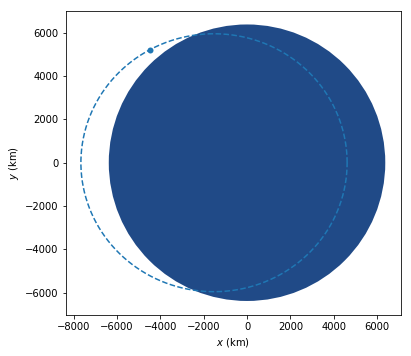

In [44]:
plot(TestOrbit)

In [48]:
# If the perigee is less than Earth Radius.
if( TestOrbit.a * (1-TestOrbit.ecc) < Earth.R):
    print("Orbit fails. crash")

Orbit fails. crash


In [49]:
GS_av_unitary

array([0.63403619, 0.02206028, 0.77298865])

In [50]:
z_unitary = np.array([0, 0, 1])

In [51]:
GS_av_unitary.view()

array([0.63403619, 0.02206028, 0.77298865])

In [52]:
np.cross(GS_av_unitary, z_unitary)

array([ 0.02206028, -0.63403619,  0.        ])

In [53]:
vec_in_plane = np.cross(GS_av_unitary, z_unitary)

In [58]:
v_1 = vec_in_plane / norm( list(vec_in_plane) )

In [63]:
GS_av_unitary

array([0.63403619, 0.02206028, 0.77298865])

In [60]:
v_1

array([ 0.03477237, -0.99939526,  0.        ])

In [64]:
v_2 = np.cross( GS_av_unitary, v_1 )

In [65]:
v_2

array([ 0.77252119,  0.02687864, -0.63441985])

In [68]:
np.cross(v_2, GS_av_unitary).dot(v_1)

0.9999999999999996

The plane is defined by the vectors v_1 and v_2. The point R_0 is in the plane.

In [69]:
v_1.dot(v_2)

-3.469446951953614e-18

In [71]:
v_2.dot(GS_av_unitary)

-5.551115123125783e-17

In [72]:
GS_av_unitary.dot(v_1)

0.0

In [80]:

r = random.random()


In [81]:
print( np.sin( 2 * np.pi * r))

0.985498820590348 -0.16968227548872938


In [85]:
radius = 600 #(km)

u_1 = np.cos( 2 * np.pi * r) * radius
u_2 = np.sin( 2 * np.pi * r) * radius
u_3 = 7000 # (km)


speed = 10 #(km/s)

nu_1 = - np.cos( 2 * np.pi * r) * speed
nu_2 = - np.sin( 2 * np.pi * r) * speed
nu_3 = 0 

In [86]:
[u_1, u_2, u_3]

[591.2992923542088, -101.80936529323763, 7000]

In [87]:
GS_av_unitary

array([0.63403619, 0.02206028, 0.77298865])

In [115]:
# Warning: The arguments of np.arctan2 are:
# arctan2( Ycoord , Xcoord )
phi = np.arctan2(GS_av_unitary[1], GS_av_unitary[0])

In [184]:
rho = ( GS_av_unitary[0]**2 + GS_av_unitary[1]**2 )**0.5

theta = np.arctan( GS_av_unitary[2]/ rho )

In [185]:
#theta  = np.pi/2   # Angle (in radians) of rotation around the z axis
#phi    = np.pi/4   # Angle (in radians) of rotation around the x axis
#v_test = np.array([0,0,1])


R_z = np.array([[np.cos(theta), -np.sin(theta), 0],
                [np.sin(theta),  np.cos(theta), 0],
                [            0,              0, 1]])

R_x = np.array([[ 1,           0,            0],
                [ 0, np.cos(phi), -np.sin(phi)],
                [ 0, np.sin(phi),  np.cos(phi)]])

ROTATION = np.matmul(R_x, R_z)

print(ROTATION)

#v_final = ROTATION.dot(v_test)
    
#print( v_final)
#print( norm(v_final))

[[ 0.63441985 -0.77298865  0.        ]
 [ 0.54658552  0.44860258 -0.70710678]
 [ 0.54658552  0.44860258  0.70710678]]
